# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#!pip install pmdarima 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from fbprophet import Prophet as proph

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('data/new_zillow_data.csv')

In [4]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,193814.0,...,1036773.0,1039292.0,1051475.0,1052389.0,1062227.0,1073321.0,1088262.0,1101458.0,1110816.0,1117997.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,262402.0,...,497434.0,499976.0,502451.0,504692.0,507078.0,508667.0,510851.0,513170.0,516360.0,519384.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,261664.0,...,1105905.0,1101323.0,1092186.0,1083389.0,1083178.0,1081122.0,1084203.0,1086301.0,1088716.0,1088755.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201649.0,...,345982.0,349035.0,353498.0,358004.0,363402.0,369313.0,376254.0,383839.0,392947.0,403712.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,353678.0,...,635561.0,638519.0,641360.0,643819.0,646973.0,649403.0,652545.0,654806.0,658509.0,661889.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30839 entries, 0 to 30838
Columns: 316 entries, RegionID to 2021-07-31
dtypes: float64(307), int64(3), object(6)
memory usage: 74.3+ MB


In [6]:
df[df.RegionName == 21532]

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
7439,66899,7510,21532,Zip,MD,MD,Frostburg,Cumberland,Allegany County,61791.0,...,105512.0,106089.0,107488.0,108782.0,110307.0,112570.0,114839.0,117788.0,119612.0,122002.0


# Step 2: Data Preprocessing

In [7]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [8]:
#datetimes = get_datetimes(df)

In [9]:
#datetimes

In [10]:
#date_dict = {}
#for key, value in list(zip(df.columns[7:], datetimes)):
#    date_dict[key] = value

In [11]:
#df.rename(columns=date_dict)

# Step 3: EDA and Visualization

In [12]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}
#
#matplotlib.rc('font', **font)
#
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [13]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,193814.0,...,1036773.0,1039292.0,1051475.0,1052389.0,1062227.0,1073321.0,1088262.0,1101458.0,1110816.0,1117997.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,262402.0,...,497434.0,499976.0,502451.0,504692.0,507078.0,508667.0,510851.0,513170.0,516360.0,519384.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,261664.0,...,1105905.0,1101323.0,1092186.0,1083389.0,1083178.0,1081122.0,1084203.0,1086301.0,1088716.0,1088755.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201649.0,...,345982.0,349035.0,353498.0,358004.0,363402.0,369313.0,376254.0,383839.0,392947.0,403712.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,353678.0,...,635561.0,638519.0,641360.0,643819.0,646973.0,649403.0,652545.0,654806.0,658509.0,661889.0


## Absolute Price Gain in 22, 10, and 5 Years

In [14]:
df['total_increase'] = df['2021-07-31'] - df['2001-07-31']
df['ten_year_increase'] = df['2021-07-31'] - df['2011-07-31']
df['five_year_increase'] = df['2021-07-31'] - df['2016-07-31']

In [15]:
df[['total_increase', 'ten_year_increase', 'five_year_increase']].isna().sum()

total_increase        11913
ten_year_increase      2393
five_year_increase      563
dtype: int64

In [16]:
total_increase_top_ten = df.sort_values('total_increase', ascending=False)[:10]
ten_year_increase_top_ten = df.sort_values('ten_year_increase', ascending=False)[:10]
five_year_increase_top_ten = df.sort_values('five_year_increase', ascending=False)[:10]

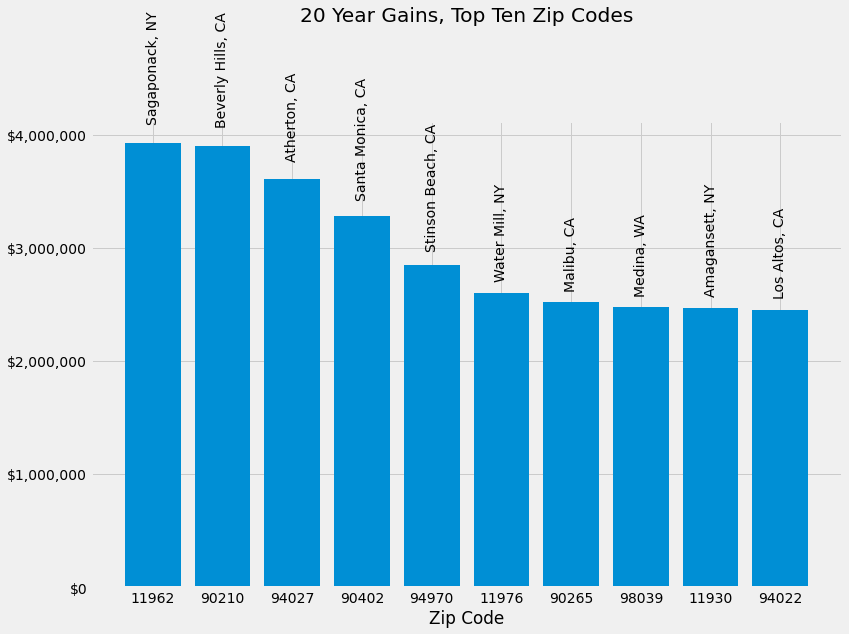

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(total_increase_top_ten.RegionName.astype('str'), total_increase_top_ten.total_increase)
ax.set_title('20 Year Gains, Top Ten Zip Codes', y=1.2)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 4000000, 5))
ax.set_yticklabels(['$0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            total_increase_top_ten.City.values[i] + ', ' + total_increase_top_ten.State.values[i], 
            ha='center', rotation='vertical');

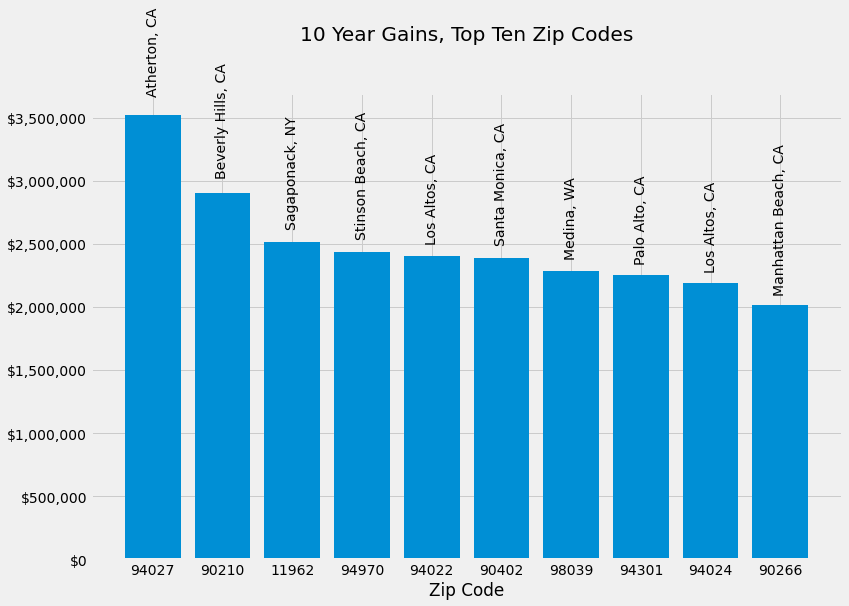

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(ten_year_increase_top_ten.RegionName.astype('str'), ten_year_increase_top_ten.ten_year_increase)
ax.set_title('10 Year Gains, Top Ten Zip Codes', y=1.1)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 3500000, 8))
ax.set_yticklabels(['$0','$500,000','$1,000,000','$1,500,000','$2,000,000','$2,500,000','$3,000,000',
                   '$3,500,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            ten_year_increase_top_ten.City.values[i] + ', ' + ten_year_increase_top_ten.State.values[i], 
            ha='center', rotation='vertical');

In [19]:
five_year_increase_top_ten.State.values[0]

'CA'

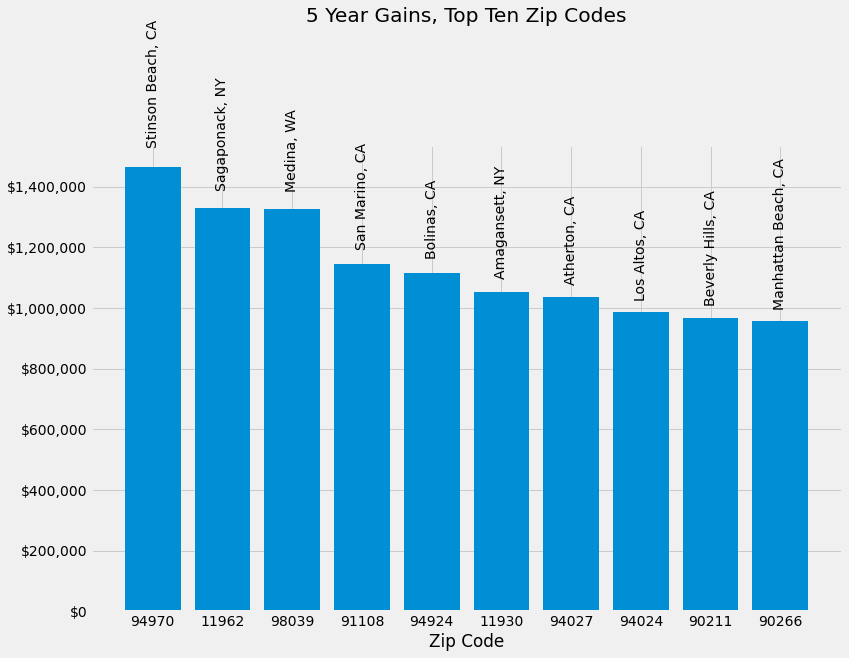

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(five_year_increase_top_ten.RegionName.astype('str'), five_year_increase_top_ten.five_year_increase)
ax.set_title('5 Year Gains, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 1400000, 8))
ax.set_yticklabels(['$0','$200,000','$400,000','$600,000',
                   '$800,000','$1,000,000','$1,200,000','$1,400,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            five_year_increase_top_ten.City.values[i] + ', ' + five_year_increase_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## Return on Investment (ROI) in 22, 10, and 5 Years for Homes of Any Price

In [21]:
df['total_roi'] = (df['2021-07-31'] - df['2001-07-31']) / df['2001-07-31'] * 100
df['ten_year_roi'] = (df['2021-07-31'] - df['2011-07-31']) / df['2011-07-31'] * 100
df['five_year_roi'] = (df['2021-07-31'] - df['2016-07-31']) / df['2016-07-31'] * 100

In [22]:
over_million = df[df['2021-07-31'] > 1000000]

In [23]:
million_total_roi_top_ten = over_million.sort_values('total_roi', ascending=False)[:10]
million_ten_year_roi_top_ten = over_million.sort_values('ten_year_roi', ascending=False)[:10]
million_five_year_roi_top_ten = over_million.sort_values('five_year_roi', ascending=False)[:10]

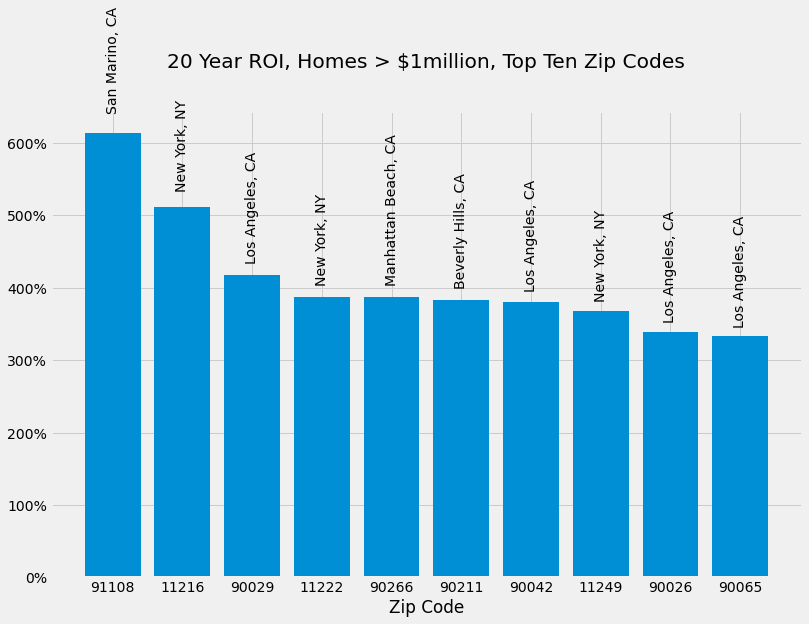

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(million_total_roi_top_ten.RegionName.astype('str'), million_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes > \$1million, Top Ten Zip Codes', y=1.08)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 600, 7))
ax.set_yticklabels(['0%', '100%', '200%', '300%', '400%', '500%', '600%'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            million_total_roi_top_ten.City.values[i] + ', ' + million_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

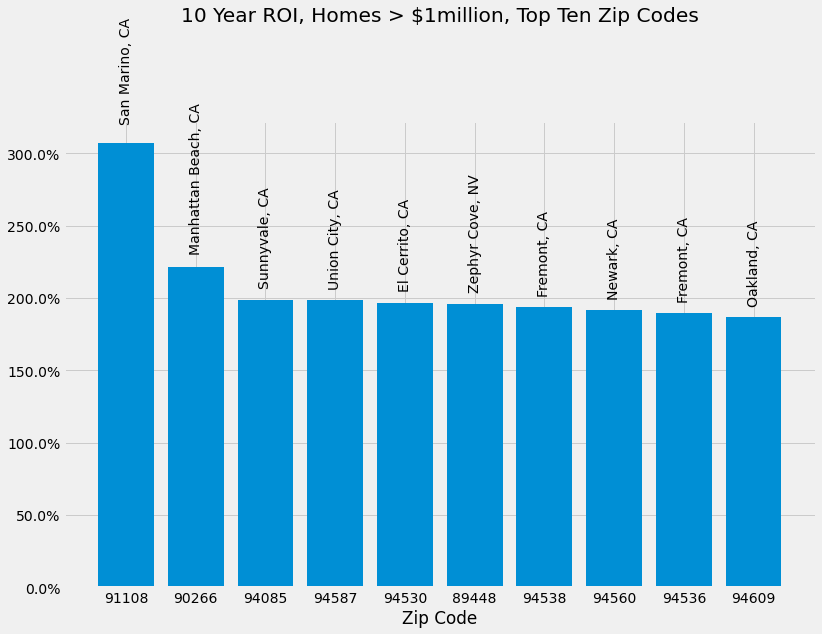

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(million_ten_year_roi_top_ten.RegionName.astype('str'), million_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes > \$1million, Top Ten Zip Codes', y=1.20)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 300, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0,300,7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            million_ten_year_roi_top_ten.City.values[i] + ', ' + million_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

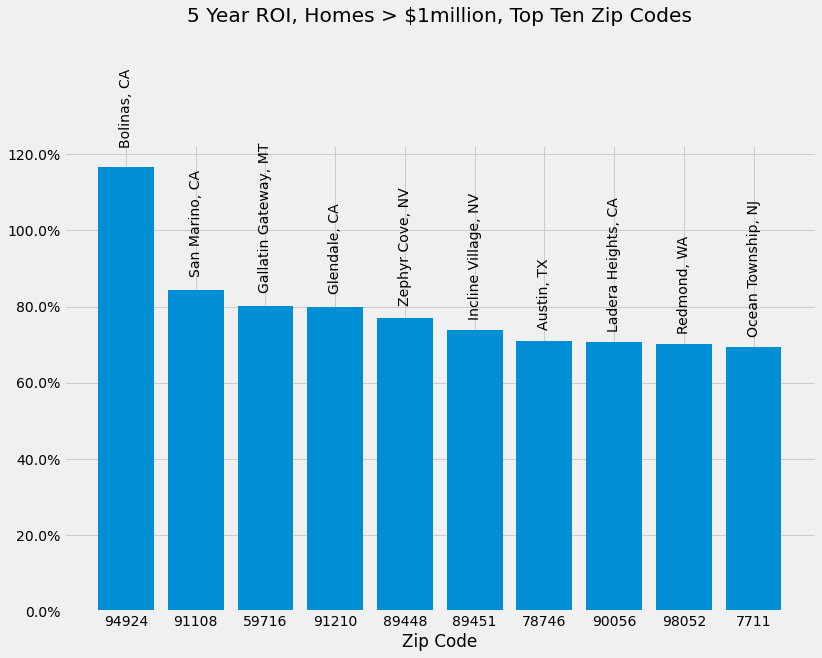

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(million_five_year_roi_top_ten.RegionName.astype('str'), million_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes > \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 120, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 120, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            million_five_year_roi_top_ten.City.values[i] + ', ' + million_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## ROI in 22, 10, and 5 Years for Homes > 500k and < 1million

In [27]:
affordable = df[(df['2021-07-31'] < 1000000) & (df['2021-07-31'] > 500000)]

In [28]:
affordable_total_roi_top_ten = affordable.sort_values('total_roi', ascending=False)[:10]
affordable_ten_year_roi_top_ten = affordable.sort_values('ten_year_roi', ascending=False)[:10]
affordable_five_year_roi_top_ten = affordable.sort_values('five_year_roi', ascending=False)[:10]

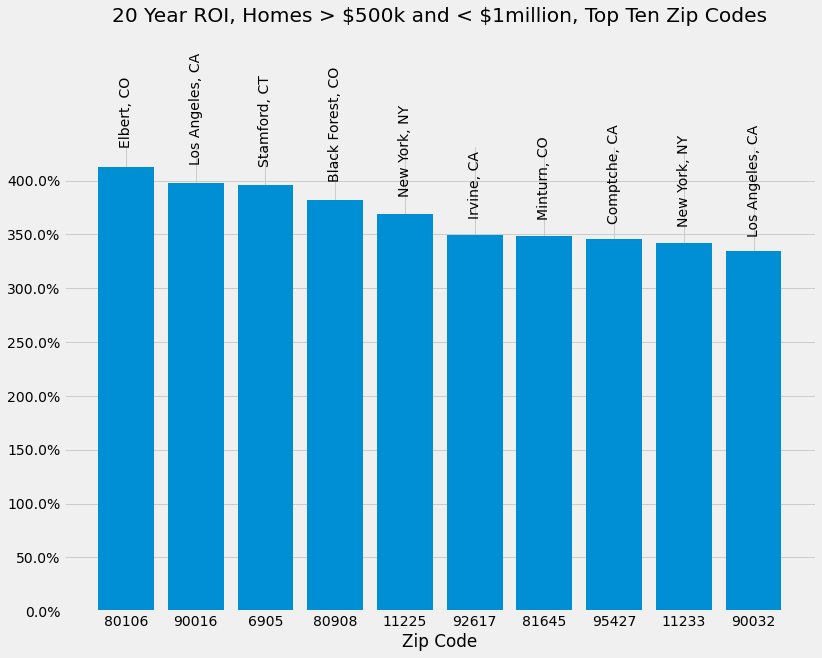

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(affordable_total_roi_top_ten.RegionName.astype('str'), affordable_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes > \$500k and < \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 400, 9))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 400, 9)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            affordable_total_roi_top_ten.City.values[i] + ', ' + affordable_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

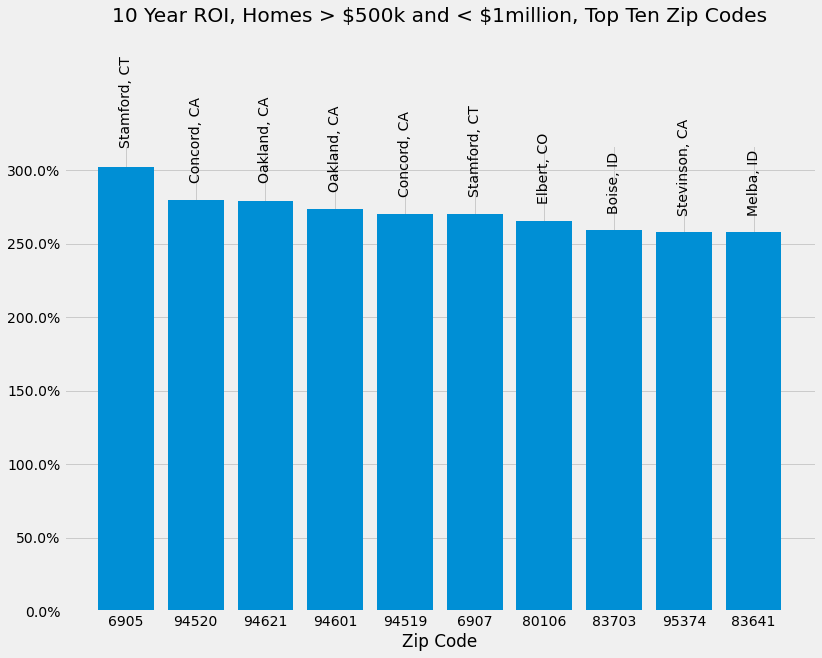

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(affordable_ten_year_roi_top_ten.RegionName.astype('str'), affordable_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes > \$500k and < \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 300, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 300, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            affordable_ten_year_roi_top_ten.City.values[i] + ', ' + affordable_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

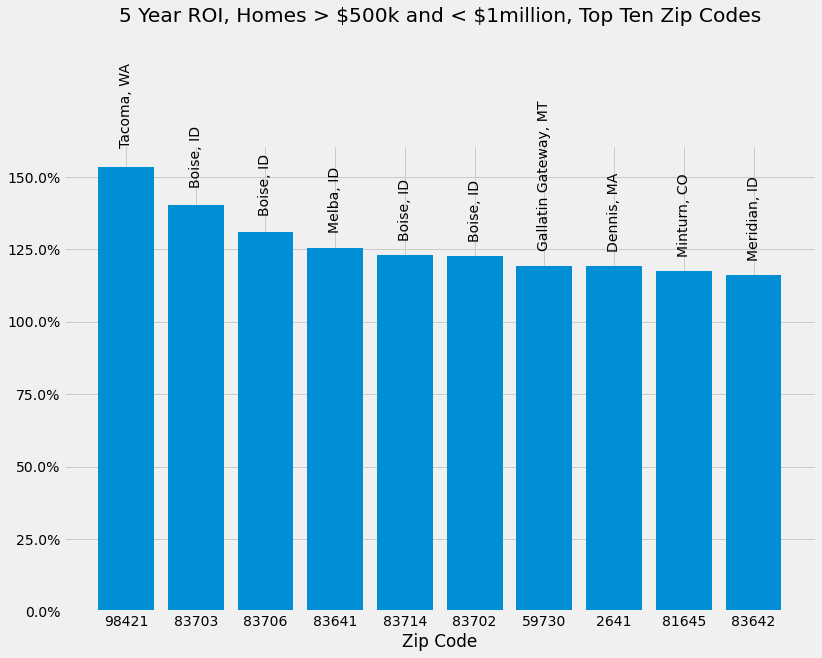

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(affordable_five_year_roi_top_ten.RegionName.astype('str'), affordable_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes > \$500k and < \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 150, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 150, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            affordable_five_year_roi_top_ten.City.values[i] + ', ' + affordable_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## ROI in 22, 10, and 5 Years for Homes > 250k and < 500k

In [32]:
less_500k = df[(df['2021-07-31'] < 500000) & (df['2021-07-31'] > 250000)]

In [33]:
less_500k_total_roi_top_ten = less_500k.sort_values('total_roi', ascending=False)[:10]
less_500k_ten_year_roi_top_ten = less_500k.sort_values('ten_year_roi', ascending=False)[:10]
less_500k_five_year_roi_top_ten = less_500k.sort_values('five_year_roi', ascending=False)[:10]

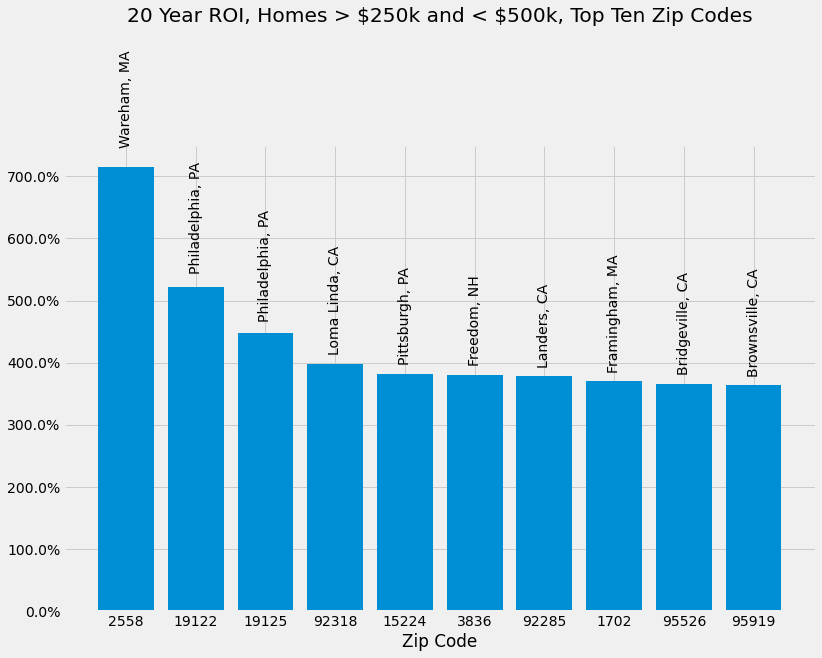

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_500k_total_roi_top_ten.RegionName.astype('str'), less_500k_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes > \$250k and < \$500k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 700, 8))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 700, 8)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_500k_total_roi_top_ten.City.values[i] + ', ' + less_500k_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

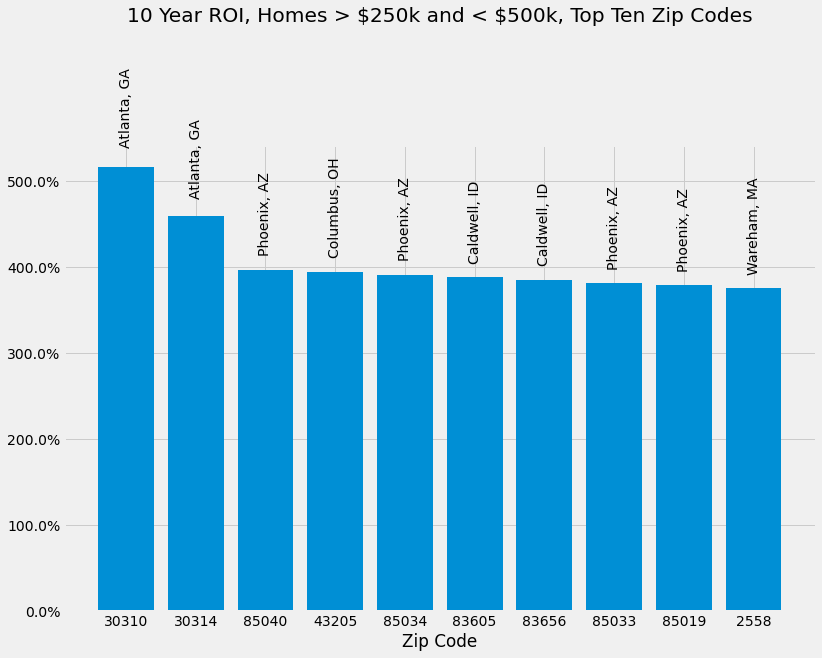

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_500k_ten_year_roi_top_ten.RegionName.astype('str'), less_500k_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes > \$250k and < \$500k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 500, 6)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_500k_ten_year_roi_top_ten.City.values[i] + ', ' + less_500k_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

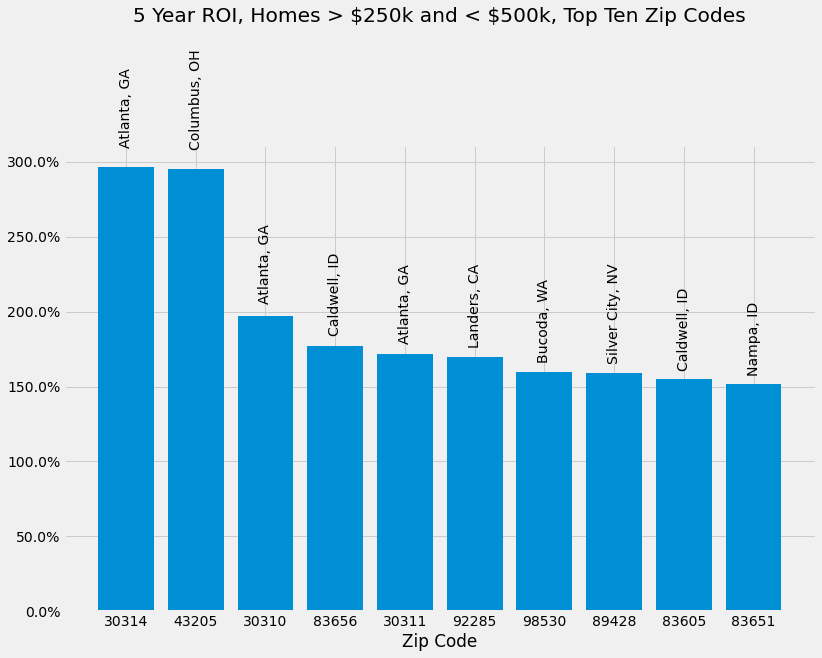

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_500k_five_year_roi_top_ten.RegionName.astype('str'), less_500k_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes > \$250k and < \$500k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 300, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 300, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_500k_five_year_roi_top_ten.City.values[i] + ', ' + less_500k_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## ROI in 22, 10, and 5 Years for Homes < 250k

In [37]:
less_250k = df[df['2021-07-31'] < 250000]

In [38]:
less_250k_total_roi_top_ten = less_250k.sort_values('total_roi', ascending=False)[:10]
less_250k_ten_year_roi_top_ten = less_250k.sort_values('ten_year_roi', ascending=False)[:10]
less_250k_five_year_roi_top_ten = less_250k.sort_values('five_year_roi', ascending=False)[:10]

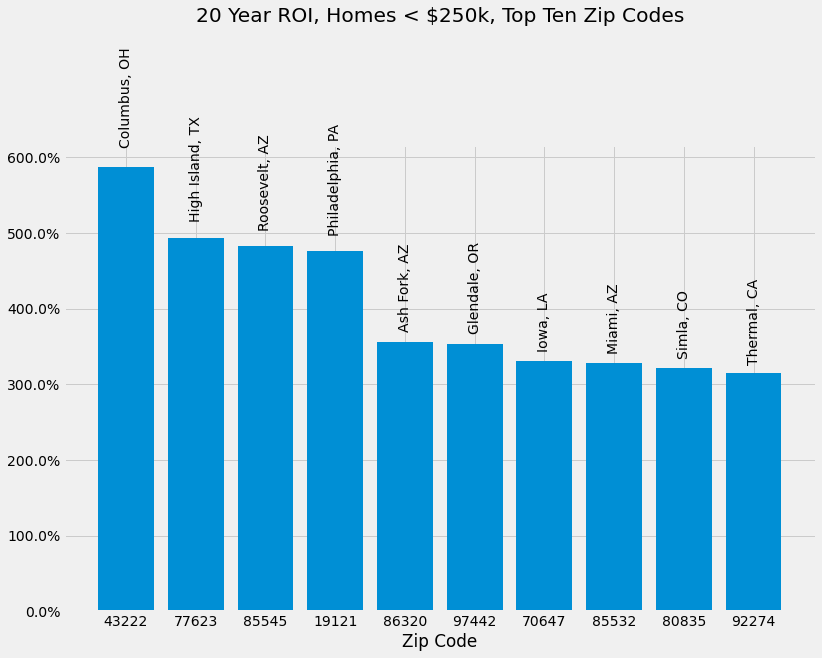

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_250k_total_roi_top_ten.RegionName.astype('str'), less_250k_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes < $250k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 600, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 600, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_250k_total_roi_top_ten.City.values[i] + ', ' + less_250k_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

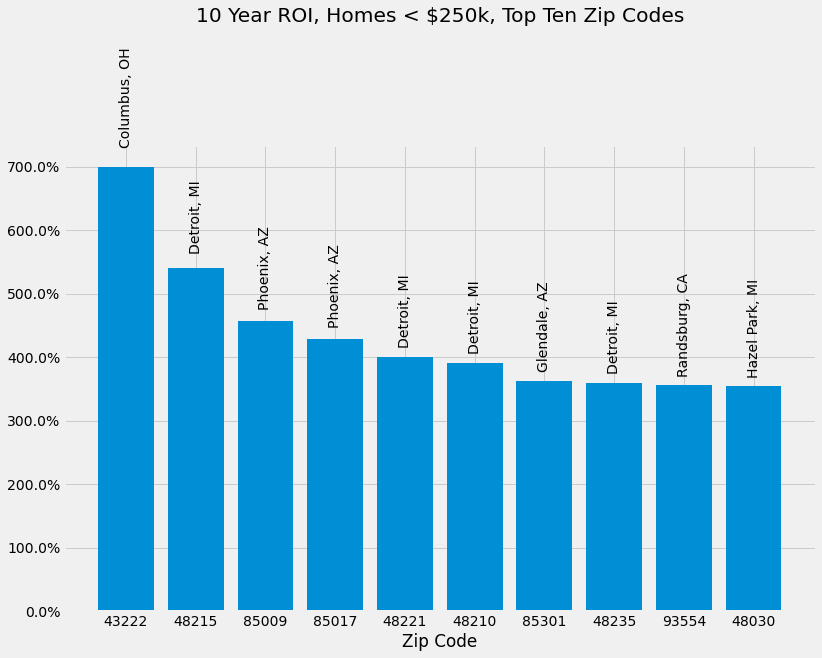

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_250k_ten_year_roi_top_ten.RegionName.astype('str'), less_250k_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes < $250k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 700, 8))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 700, 8)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_250k_ten_year_roi_top_ten.City.values[i] + ', ' + less_250k_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

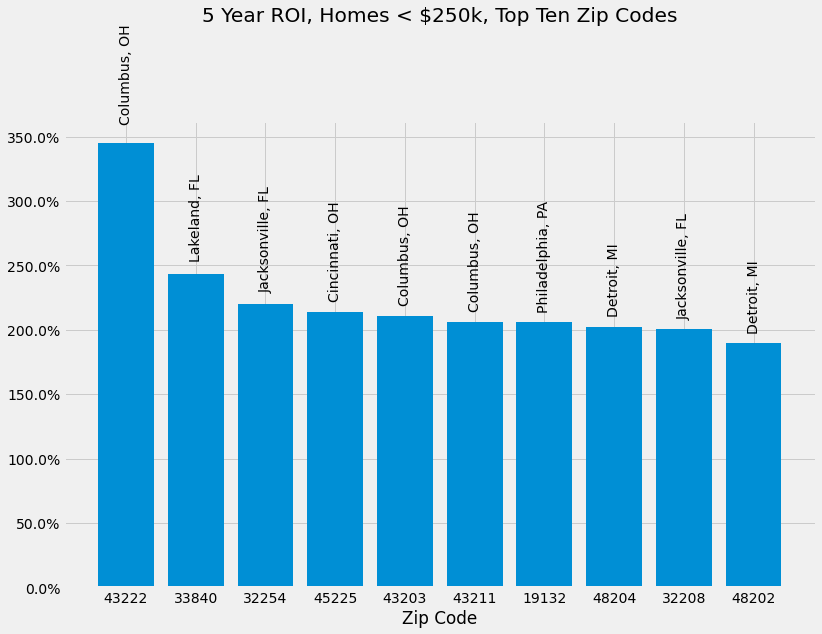

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_250k_five_year_roi_top_ten.RegionName.astype('str'), less_250k_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes < $250k, Top Ten Zip Codes', y=1.2)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 350, 8))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 350, 8)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_250k_five_year_roi_top_ten.City.values[i] + ', ' + less_250k_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

In [240]:
df2 = pd.read_csv('data/rdc_data.csv')

In [279]:
df2.head()

,postal_code,month_date_yyyymm,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,77365,202106,33.0,-0.326531,-0.435897,68.0,0.0000,-0.2917,32.0,0.0,0.0000,12.0,0.5000,-0.8125,2.250000,-1.1944,1.4988
1,30318,202106,31.5,0.050000,-0.382353,212.0,0.1522,0.0600,4.0,0.0,-0.5000,60.0,0.1538,-0.6250,1.510823,-0.3136,0.7989
2,84005,202106,8.0,1.666667,-0.724138,116.0,0.0741,0.3810,8.0,0.0,-0.8947,16.0,0.3333,1.0000,6.509091,-1.4211,2.4878
3,80107,202106,15.0,-0.464286,-0.577465,32.0,0.1429,0.1429,8.0,1.0,-0.3333,4.0,0.0000,-0.8750,1.916667,-0.6716,0.8137
4,98626,202106,33.0,0.571429,-0.297872,40.0,-0.2308,0.2500,24.0,1.0,2.0000,8.0,0.0000,-0.5000,3.080000,-0.1927,2.2173


In [278]:
find_zip = df2[df2.postal_code == 98421]
find_zip

,postal_code,month_date_yyyymm,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy


In [281]:
df2.month_date_yyyymm.unique()

array([202106, 202107, 202105, 202104, 202103, 202102, 202101, 202012,
       202011, 202010, 202009, 202008, 202007, 202006, 202005, 202004,
       202003, 202002, 202001, 201912, 201911, 201910, 201909, 201908,
       201907, 201906, 201905, 201904, 201903, 201902, 201901, 201812,
       201811, 201810, 201809, 201808, 201807, 201806, 201805, 201804,
       201803, 201802, 201801, 201712, 201711, 201710, 201709, 201708,
       201707])

In [275]:
days_on_market = df2.groupby('postal_code').median_days_on_market.mean().reset_index()

In [277]:
days_on_market.sort_values('median_days_on_market')[:10]

,postal_code,median_days_on_market
2913,80239,7.000000
2953,80916,12.000000
2872,80012,12.500000
766,28262,13.500000
3030,84047,14.500000
2957,80922,14.785714
2905,80219,15.000000
3051,84117,15.000000
2914,80241,16.000000
3548,92688,16.500000


In [274]:
len(days_on_market)

3926

# Step 4: Reshape from Wide to Long Format

In [44]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [45]:
cols_to_drop = ['total_increase', 'ten_year_increase', 'five_year_increase',
               'total_roi', 'ten_year_roi', 'five_year_roi']
df.drop(cols_to_drop, axis=1, inplace=True)

In [46]:
melted = melt_data(df)

In [47]:
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,time,value
0,10025,61639,0,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,1996-01-31,193814.0
1,60657,84654,1,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,1996-01-31,262402.0
2,10023,61637,2,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,1996-01-31,261664.0
3,77494,91982,3,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,Zip,TX,1996-01-31,201649.0
4,60614,84616,4,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,1996-01-31,353678.0


In [48]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7650220 entries, 0 to 9467572
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   RegionType  object        
 8   StateName   object        
 9   time        datetime64[ns]
 10  value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 700.4+ MB


In [49]:
melted['time'] = pd.to_datetime(melted['time'])

In [50]:
melted.set_index('time', inplace=True)

In [51]:
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
1996-01-31,10025,61639,0,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,193814.0
1996-01-31,60657,84654,1,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,262402.0
1996-01-31,10023,61637,2,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,261664.0
1996-01-31,77494,91982,3,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,Zip,TX,201649.0
1996-01-31,60614,84616,4,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,353678.0


# Best Zip Code Time Series

In [52]:
def DickeyFullerTest(ts):
    
    '''
    Takes in a time series and returns the results of the Dickey Fuller Test in a Panda Series format.
    '''

    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value

    return dfoutput

In [53]:
def decompose(ts):
    '''
    Takes in a time series and returns four plots: the orignal, trend, seasonal, and residuals.
    '''

    decomposition = seasonal_decompose(ts)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(15,8))
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left');

In [54]:
frostburg = melted[melted.RegionName == 21532]

In [55]:
frostburg

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
1996-01-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61791.0
1996-02-29,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61614.0
1996-03-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61487.0
1996-04-30,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61259.0
1996-05-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61070.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,112570.0
2021-04-30,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,114839.0
2021-05-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,117788.0


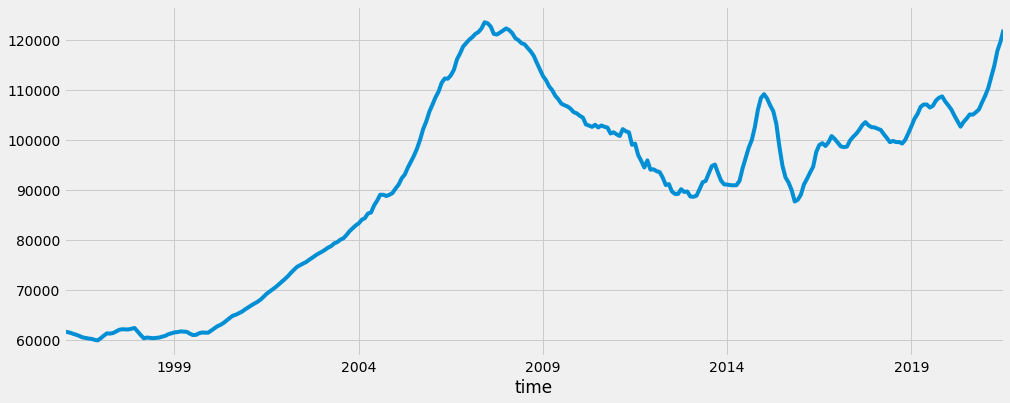

In [56]:
frostburg.value.plot(figsize=(15,6));

## 43222 Columbus, OH:  Best ROI less thatn 250k 

In [57]:
less_250k_best_zip = less_250k.sort_values('five_year_roi', ascending=False)[:1]['RegionName'].values

In [58]:
less_250k_best_zip

array([43222])

In [59]:
int(less_250k_best_zip)

43222

In [60]:
columbus_43222 = melted[melted.RegionName == int(less_250k_best_zip)]

In [61]:
columbus_43222 = columbus_43222.resample('MS').mean()

In [62]:
columbus_43222

,RegionName,RegionID,SizeRank,value
time,,,,
1996-01-01,43222,76590,14840,26584.0
1996-02-01,43222,76590,14840,25884.0
1996-03-01,43222,76590,14840,25538.0
1996-04-01,43222,76590,14840,24695.0
1996-05-01,43222,76590,14840,24074.0
...,...,...,...,...
2021-03-01,43222,76590,14840,150342.0
2021-04-01,43222,76590,14840,154981.0
2021-05-01,43222,76590,14840,160457.0


In [63]:
columbus_43222 = columbus_43222.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

In [64]:
columbus_43222

,value
time,
1996-01-01,26584.0
1996-02-01,25884.0
1996-03-01,25538.0
1996-04-01,24695.0
1996-05-01,24074.0
...,...
2021-03-01,150342.0
2021-04-01,154981.0
2021-05-01,160457.0


### Check rolling mean and std. deviation

In [235]:
def roll_mean_std(ts, name='Enter Name'):
    """
    Takes a time series and name and returns a plot of rolling mean and std.
    
    Parameters
    ----------
    
    ts:  time series
    name:  ts name for the plot title.  (ex. '43222 (Columbus, OH)')
    """
    
    roll_mean = ts.rolling(window=12).mean()
    roll_std = ts.rolling(window=12).std()

    fig = plt.figure(figsize=(15,8))
    plt.plot(ts, label='Original')
    plt.plot(roll_mean, label='1 Yr. Rolling Mean')
    plt.plot(roll_std, label=('1 Yr. Rolling Std.'))
    plt.legend(loc='best')
    plt.title(f'{name} Rolling Mean & Std. Deviation');

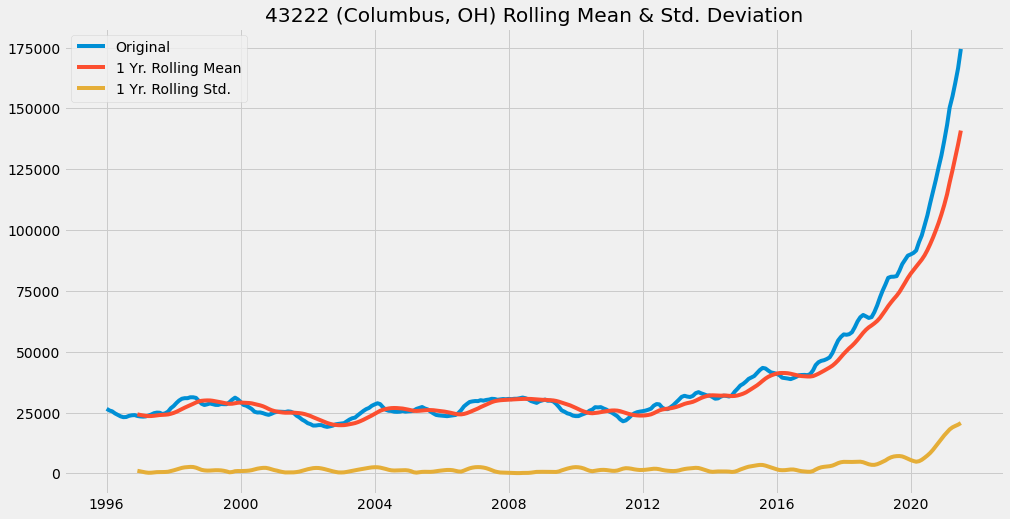

In [236]:
roll_mean_std(columbus_43222, name='43222 (Columbus, OH)')

### Check seasonal decomposition

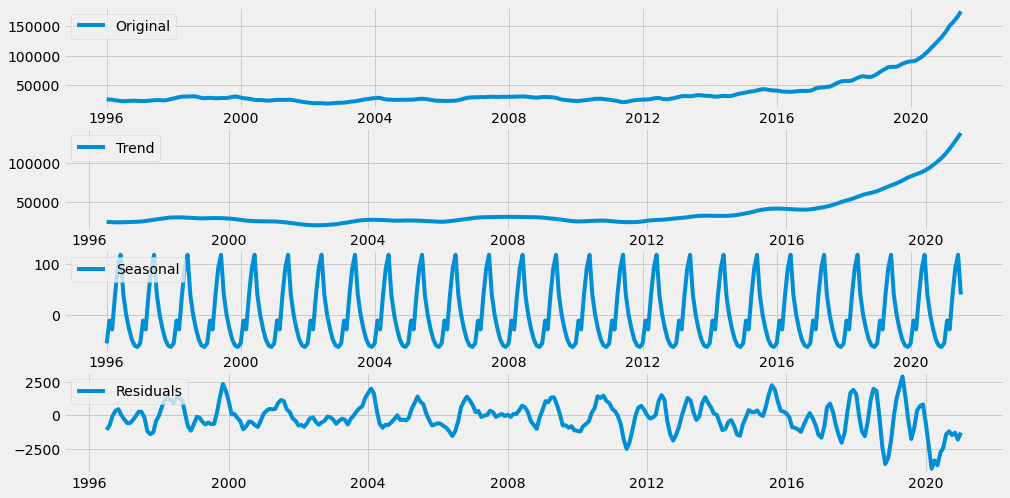

In [66]:
decompose(columbus_43222)

### Check Dickey Fuller test

In [67]:
DickeyFullerTest(columbus_43222)

Test Statistic                   3.005380
p-value                          1.000000
# Lags Used                     16.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64

Clearly there is an upward trend. The Dickey Fuller Test p-value of .973 confirms this.

### Try first order differencing

In [68]:
columbus_43222_diff = columbus_43222.diff()
columbus_43222_diff.dropna(inplace=True)

In [69]:
columbus_43222_diff

,value
time,
1996-02-01,-700.0
1996-03-01,-346.0
1996-04-01,-843.0
1996-05-01,-621.0
1996-06-01,-594.0
...,...
2021-03-01,7091.0
2021-04-01,4639.0
2021-05-01,5476.0


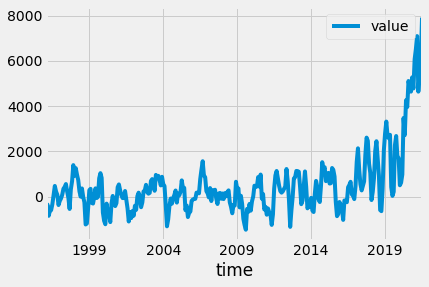

In [70]:
columbus_43222_diff.plot();

In [71]:
DickeyFullerTest(columbus_43222_diff)

Test Statistic                   3.762039
p-value                          1.000000
# Lags Used                     16.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

The p_value is just over the theshold of .05.  Let's try second order differencing.

### Try second order differencing.  

In [72]:
columbus_43222_diff2 = columbus_43222_diff.diff()
columbus_43222_diff2.dropna(inplace=True)

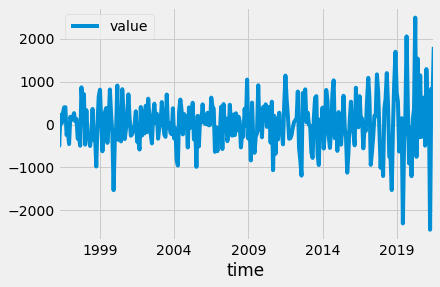

In [73]:
columbus_43222_diff2.plot();

In [74]:
DickeyFullerTest(columbus_43222_diff2)

Test Statistic                  -3.234630
p-value                          0.018066
# Lags Used                     16.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64

The p-value is now well below the threshold.

### Try PACF and ACF 

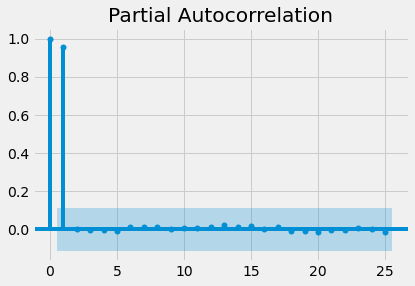

In [75]:
plot_pacf(columbus_43222);

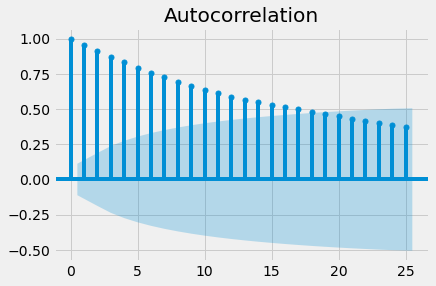

In [76]:
plot_acf(columbus_43222);

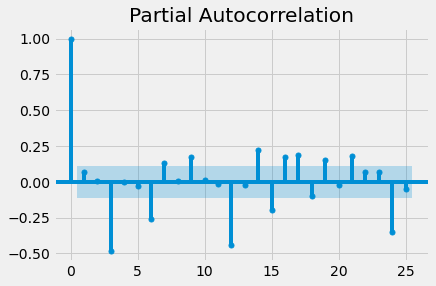

In [77]:
plot_pacf(columbus_43222_diff2);

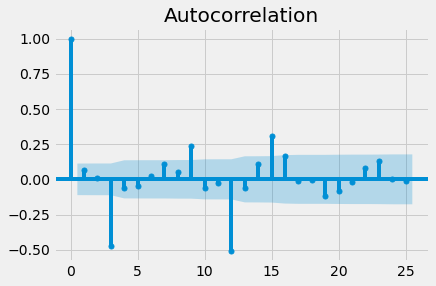

In [78]:
plot_acf(columbus_43222_diff2);

### Train Test Split

In [282]:
def train_test_split(ts, train_size=.8):
    """
    Takes in a time series and creates and train test split.
    
    Parameters
    ----------
    
    ts: time series
    train size: (float) portion of time series reserved for train (default=.8)
    """
    cutoff = round(ts.shape[0]*.8)
    train = ts[:cutoff]
    test = ts[cutoff:]

In [79]:

cutoff = round(columbus_43222.shape[0]*.8)
train = columbus_43222[:cutoff]
test = columbus_43222[cutoff:]

### Baseline Model

In [155]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def naive_model(train, test, periods=1):
    
    """
    Takes in train and test data.  Shifts data by number of periods and returns a plot and RMSEs.
    
    Parameters
    ----------
    train: training data 
    test: test data 
    periods: number of periods to shift (default = 1)
    """
    
    naive_train = train.shift(periods=1)
    naive_test = test.shift(periods=1)
    
    fig = plt.figure(figsize=(15,8))
    plt.plot(train, label='Original Train')
    plt.plot(naive_train, label='Shifted Train')
    plt.plot(test, label='Original Test')
    plt.plot(naive_test, label='Shifted Test')
    plt.legend(loc='best')
    plt.title('Naive Model');
    
    RMSE_train = np.sqrt(mean_squared_error(train[1:], naive_train.dropna()))
    RMSE_test = np.sqrt(mean_squared_error(test[1:], naive_test.dropna()))
    
    print(f'The Naive Model RMSE for the train data is: {round(RMSE_train, 2)}')
    print(f'The Naive Model RMSE for the test data is: {round(RMSE_test, 2)}')

The Naive Model RMSE for the train data is: 625.21
The Naive Model RMSE for the test data is: 3069.87


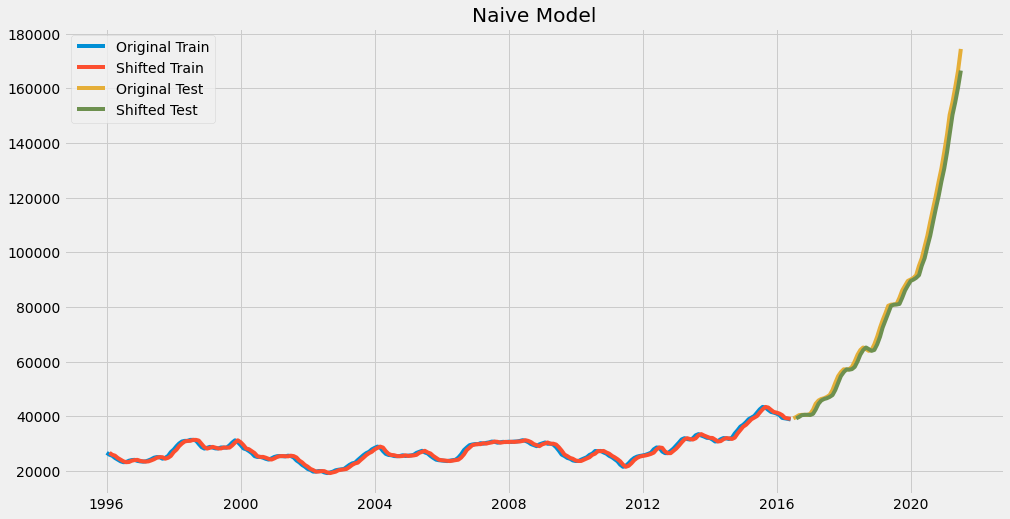

In [156]:
naive_model(train, test)

### ARIMA Modeling

In [205]:
from sklearn.model_selection import TimeSeriesSplit

def segment_data(data,train_index, test_index):
    X_train, X_test = data[0].iloc[train_index], data[0].iloc[test_index]
    if len(data)==1:
        return (X_train,None), (X_test,None)
    else:
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        return (X_train, y_train), (X_test, y_test)

def cross_validate(model, data, sklearn=True, model_kwargs={}):
    '''
    Resamples dataframe using aggregate mean
    Preforms cross validation of the input model. 
    ---------------------------------------------------------------------
    model: uninitalized model- no parantheses 
    train_data: data to train the model on. in the form of (X,y) or (X)
    test_data: *optional* data to make predictions on. in the form of (X,y) or (X)
    sklearn: whether to fit model with sklearn syntax
    model_kwargs: keyword arguments to pass into the model before fitting
    ---------------------------------------------------------------------
    Returns: means of train and test rmse
    '''
    
    all_rmse = []
    # Create and loop through 4 different train and validation sets
    split = TimeSeriesSplit(n_splits=4)
    for train_index, test_index in split.split(data[0]):
        (X_train, y_train), (X_test,y_test) = segment_data(data, train_index, test_index)
        if sklearn:
            _model = model(**model_kwargs)
            _model.fit(*train_fit)
            predictions = _model.predict(X_test)

        else:
            _model = model(X_train, **model_kwargs).fit()
            predictions = _model.predict(typ='levels', start=test_index[0], end=test_index[-1])
        if y_train:
            all_rmse.append(rmse(y_train, predictions))
        else:
            all_rmse.append(rmse(X_test, predictions))
            
        print(X_test, predictions)
    return np.mean(all_rmse)


#### Random Walk Model

In [165]:
random_walk_model = ARIMA(train, order=(0, 2, 0)).fit()
random_walk_model.aic

3678.109275065663

In [166]:
y_hat_random_walk_model = random_walk_model.predict(type='levels')
np.sqrt(mean_squared_error(train, y_hat_random_walk_model))

2004.330956085682

In [167]:
model_1 = ARIMA(train, order=(1, 2, 1)).fit()
model_1.aic

3653.9615555723394

In [168]:
y_hat_model_1 = model_1.predict(type='levels')
np.sqrt(mean_squared_error(train, y_hat_model_1))

1988.920862507547

In [172]:
n_splits = 5
split = TimeSeriesSplit(n_splits=n_splits)
tot_RMSE = 0
train_with_ind = train.reset_index()
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1,2,1)).fit()
    preds = ar.predict(type='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    RMSE = np.sqrt(mean_squared_error(true, preds))
    print(RMSE)
    tot_RMSE += RMSE
print(f'Cross Validate Average RMSE: {tot_RMSE/n_splits}')

10643.393721885512
3121.6607007634157
7778.206780390232
35449.643926311466
19033.96433197508
Cross Validate Average RMSE: 15205.373892265143


In [207]:
train.isna().sum()

value    0
dtype: int64

In [206]:
cross_validate(ARIMA,(train,), sklearn=False, model_kwargs={'order':(1,2,1)})


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [90]:
model_sarimax = SARIMAX(train, order=(0, 1, 0), seasonal_order=(2, 2, 0, 12),
                       enforce_stationarity=False, enforce_invertibility=False).fit()
model_sarimax.aic

3313.158465785462

In [230]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

def sarimax_search(train, p=range(1,3), d=range(1,2), q=range(1,3),
                   enforce_stationarity=False, enforce_invertibility=False):
    
    """
    Takes in training data and p, q, d, and returns SARIMAX models with RMSE.  After all iterations,
    prints the best model and RMSE.
    
    Parameters
    ----------
    train = training data
    p: (range) for the iterations of p in SARIMAX model, default = range(1,3)
    d: (range) for the iterations of d in SARIMAX model, default = range(1,2)
    q: (range) for the iterations of q in SARIMAX model, default = range(1,3)
    enforce_stationarity:  default = False
    enforce_invertibility: default = False
    """
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
    
    count = 0
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            count += 1
    print(f'THERE ARE {count} ITERATIONS')
    answer = input("Would you like to run the models? (y or n)?")
    
    if (answer == 'y' or answer == 'yes'):
        lowest_RMSE = 1e10
        for param in pdq: 
            for seasonal_param in seasonal_pdq:
                try: 
                    model = SARIMAX(train, order=param, seasonal_order=seasonal_param,
                                   enforce_stationarity=enforce_stationarity, 
                                    enforce_invertibility=enforce_invertibility)
                    results = model.fit()
                    y_hat = results.predict(type='levels')
                    RMSE = np.sqrt(mean_squared_error(train, y_hat))
                    print(f'SARIMAX {param} x {seasonal_param} - RMSE:{RMSE}')
                    if RMSE < lowest_RMSE:
                        lowest_RMSE = RMSE
                        best_param = param
                        best_seasonal_param = seasonal_param
                except:
                    print('Oops!')
                    continue
        print(f'BEST RESULTS:  SARIMAX {best_param} x {best_seasonal_param} - RMSE:{lowest_RMSE}')  
    else:
        print('OK, SARIMAX models will not be run.')

In [231]:
sarimax_search(train, p=range(0,3), d=range(1,3), q=range(0,3))

THERE ARE 324 ITERATIONS
Would you like to run the models? (y or n)?y
SARIMAX (0, 1, 0) x (0, 1, 0, 12) - RMSE:2284.2068186625684
SARIMAX (0, 1, 0) x (0, 1, 1, 12) - RMSE:2167.5775817149724
SARIMAX (0, 1, 0) x (0, 1, 2, 12) - RMSE:2150.556603486928
SARIMAX (0, 1, 0) x (0, 2, 0, 12) - RMSE:3374.9783249190605
SARIMAX (0, 1, 0) x (0, 2, 1, 12) - RMSE:2953.5509063104328
SARIMAX (0, 1, 0) x (0, 2, 2, 12) - RMSE:2899.3798101045227
SARIMAX (0, 1, 0) x (1, 1, 0, 12) - RMSE:2091.547622192644
SARIMAX (0, 1, 0) x (1, 1, 1, 12) - RMSE:2139.9709805899156
SARIMAX (0, 1, 0) x (1, 1, 2, 12) - RMSE:2108.9065324643934
SARIMAX (0, 1, 0) x (1, 2, 0, 12) - RMSE:2852.5300366222878
SARIMAX (0, 1, 0) x (1, 2, 1, 12) - RMSE:2730.050764692005
SARIMAX (0, 1, 0) x (1, 2, 2, 12) - RMSE:2878.780384936058
SARIMAX (0, 1, 0) x (2, 1, 0, 12) - RMSE:2054.7544626123554
SARIMAX (0, 1, 0) x (2, 1, 1, 12) - RMSE:2131.36532853227
SARIMAX (0, 1, 0) x (2, 1, 2, 12) - RMSE:2193.067737813858
SARIMAX (0, 1, 0) x (2, 2, 0, 12) - R

SARIMAX (1, 1, 1) x (1, 2, 2, 12) - RMSE:2814.751637647277
SARIMAX (1, 1, 1) x (2, 1, 0, 12) - RMSE:2145.842527030152
SARIMAX (1, 1, 1) x (2, 1, 1, 12) - RMSE:2153.035447696929
SARIMAX (1, 1, 1) x (2, 1, 2, 12) - RMSE:2190.7709448441183
SARIMAX (1, 1, 1) x (2, 2, 0, 12) - RMSE:2670.268534226279
SARIMAX (1, 1, 1) x (2, 2, 1, 12) - RMSE:2664.254402395145
SARIMAX (1, 1, 1) x (2, 2, 2, 12) - RMSE:2831.040631432071
SARIMAX (1, 1, 2) x (0, 1, 0, 12) - RMSE:2199.421641705018
SARIMAX (1, 1, 2) x (0, 1, 1, 12) - RMSE:2100.25055830203
SARIMAX (1, 1, 2) x (0, 1, 2, 12) - RMSE:2094.726862133402
SARIMAX (1, 1, 2) x (0, 2, 0, 12) - RMSE:3126.7214014470196
SARIMAX (1, 1, 2) x (0, 2, 1, 12) - RMSE:2916.5774168095727
SARIMAX (1, 1, 2) x (0, 2, 2, 12) - RMSE:2829.8981574594345
SARIMAX (1, 1, 2) x (1, 1, 0, 12) - RMSE:2066.837271202648
SARIMAX (1, 1, 2) x (1, 1, 1, 12) - RMSE:2054.6354608462116
SARIMAX (1, 1, 2) x (1, 1, 2, 12) - RMSE:2068.1877809964476
SARIMAX (1, 1, 2) x (1, 2, 0, 12) - RMSE:2754.69489

SARIMAX (2, 2, 0) x (0, 2, 2, 12) - RMSE:3062.5824119605422
SARIMAX (2, 2, 0) x (1, 1, 0, 12) - RMSE:2418.3297487778223
SARIMAX (2, 2, 0) x (1, 1, 1, 12) - RMSE:2380.0614824839754
SARIMAX (2, 2, 0) x (1, 1, 2, 12) - RMSE:2413.435351404884
SARIMAX (2, 2, 0) x (1, 2, 0, 12) - RMSE:3068.780745003599
SARIMAX (2, 2, 0) x (1, 2, 1, 12) - RMSE:2917.072064428742
SARIMAX (2, 2, 0) x (1, 2, 2, 12) - RMSE:2932.17665048872
SARIMAX (2, 2, 0) x (2, 1, 0, 12) - RMSE:2400.5862412813435
SARIMAX (2, 2, 0) x (2, 1, 1, 12) - RMSE:2373.37044513474
SARIMAX (2, 2, 0) x (2, 1, 2, 12) - RMSE:2429.5460123892663
SARIMAX (2, 2, 0) x (2, 2, 0, 12) - RMSE:2872.262808673477
SARIMAX (2, 2, 0) x (2, 2, 1, 12) - RMSE:2847.2067738278406
SARIMAX (2, 2, 0) x (2, 2, 2, 12) - RMSE:2968.162581093094
SARIMAX (2, 2, 1) x (0, 1, 0, 12) - RMSE:2694.5057812511886
SARIMAX (2, 2, 1) x (0, 1, 1, 12) - RMSE:2749.5073756937013
SARIMAX (2, 2, 1) x (0, 1, 2, 12) - RMSE:2695.247397925118
SARIMAX (2, 2, 1) x (0, 2, 0, 12) - RMSE:3506.1933

In [232]:
cross_validate(SARIMAX, train, model_kwargs={'order':(1,1,2), 'seasonal_order':(2,1,1,12),
                                            'enforce_stationarity':False, 'enforce_invertibility':False})

KeyError: 0

In [136]:
preds_list = []
split = TimeSeriesSplit(n_splits=5)
tot_RMSE = 0
train_with_ind = train.reset_index()
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1], 
                    order=(3, 1, 1), 
                    seasonal_order=(0, 0, 1, 12),
                    enforce_stationarity=False, 
                    enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    preds_list.append(preds)
    RMSE = np.sqrt(mean_squared_error(true, preds))
    print(RMSE)
    tot_RMSE += RMSE
print(f'Cross Validate Average RMSE: {tot_RMSE/5}')
    

1968300048.4541848
1274.4951839386772
4249.661722417464
2353.0971468358225
9761.574701510666
Cross Validate Average RMSE: 393663537.4565879


## AutoArima


In [237]:
out_of_sample_size = .2 * len(train)
auto_columbus = pm.auto_arima(train, 
                            start_p=0,
                            start_q=0,
                            max_p=3,
                            max_q=3,
                            d=2,
                            seasonal=True,
                            start_P=0,
                            start_Q=0,
                            max_P=3,
                            max_Q=3,
                            m=12,
                            D=None,
                            test='kpss',
                            trace=True,
                            stepwise=True,
                            n_fits=1000)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3678.109, Time=0.48 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3619.887, Time=0.22 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3550.335, Time=0.42 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3680.093, Time=0.02 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=3551.279, Time=0.64 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=3550.765, Time=0.68 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3619.925, Time=0.13 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3548.340, Time=0.15 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3549.297, Time=0.46 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=3548.790, Time=0.69 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3618.350, Time=0.05 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3550.334, Time=0.42 sec
 ARIMA(1,2,1)(0,0,1)[12]     

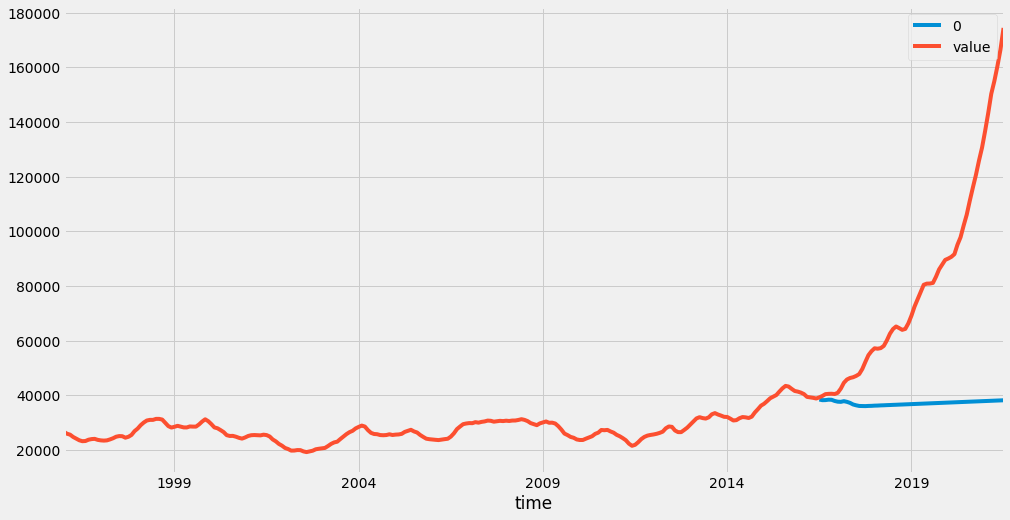

In [99]:
auto_columbus_predicitons = pd.DataFrame(auto_columbus.predict(n_periods=len(test), 
                                        type='levels'), index=test.index)

fig, ax = plt.subplots(figsize=(15,8))
auto_columbus_predicitons.plot(ax=ax, label='predicted')
columbus_43222.plot(ax=ax, label='orginial');

## Prophet

In [114]:
train_proph = train.reset_index()
train_proph = train_proph.rename(columns={'value':'y', 'time':'ds'})

test_proph = test.reset_index()
test_proph = test_proph.rename(columns={'value':'y', 'time':'ds'})

In [101]:
columbus_prophet = proph(interval_width=.95)
columbus_prophet.fit(train_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [115]:
y_hat_proph_train = columbus_prophet.predict(train_proph)
np.sqrt(mean_squared_error(train_proph.y, y_hat_proph_train.yhat))

2906.5163982629824

In [117]:
y_hat_proph_test = columbus_prophet.predict(test_proph)
np.sqrt(mean_squared_error(test_proph.y, y_hat_proph_test.yhat))

46636.39631205482

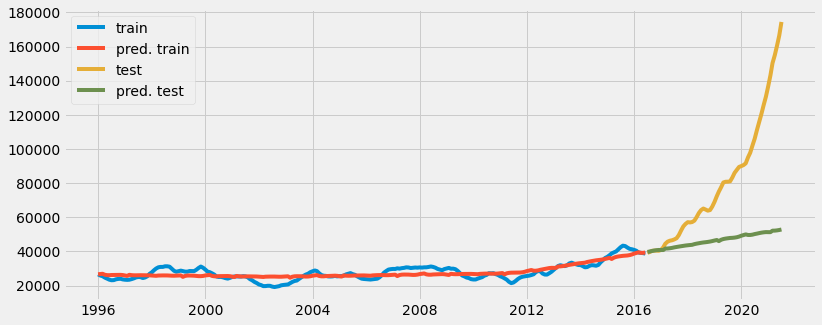

In [125]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(train_proph.ds, train_proph.y, label='train')
ax.plot(y_hat_proph_train.ds, y_hat_proph_train.yhat, label='pred. train')
ax.plot(test_proph.ds, test_proph.y, label='test')
ax.plot(y_hat_proph_test.ds, y_hat_proph_test.yhat, label='pred. test')
ax.legend();

In [103]:
future_dates = columbus_prophet.make_future_dataframe(periods=36, freq='MS')
forecast = columbus_prophet.predict(future_dates)

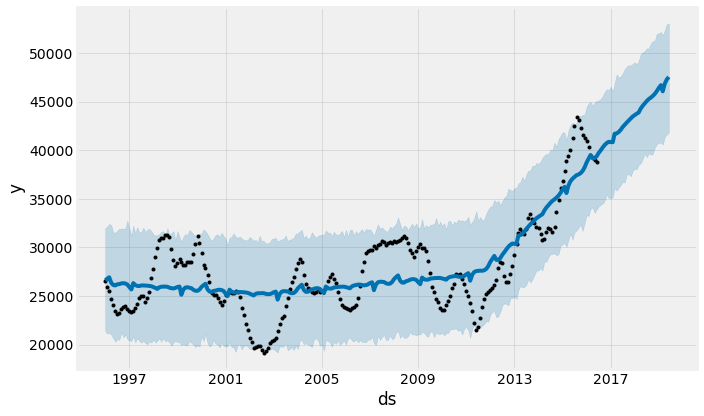

In [104]:
columbus_prophet.plot(forecast, uncertainty=True);

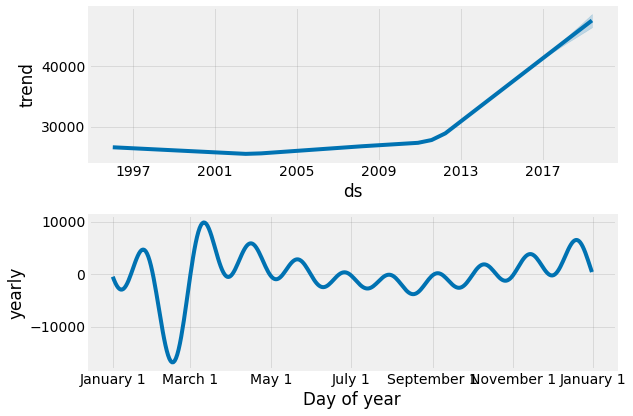

In [105]:
columbus_prophet.plot_components(forecast);

In [132]:
columbus_43222_proph = columbus_43222.reset_index()
columbus_43222_proph = columbus_43222_proph.rename(columns={'value':'y', 'time':'ds'})


In [133]:
columbus_prophet_full = proph(interval_width=.95)
columbus_prophet_full.fit(columbus_43222_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [134]:
y_hat_prophet_full = columbus_prophet_full.predict(columbus_43222_proph)

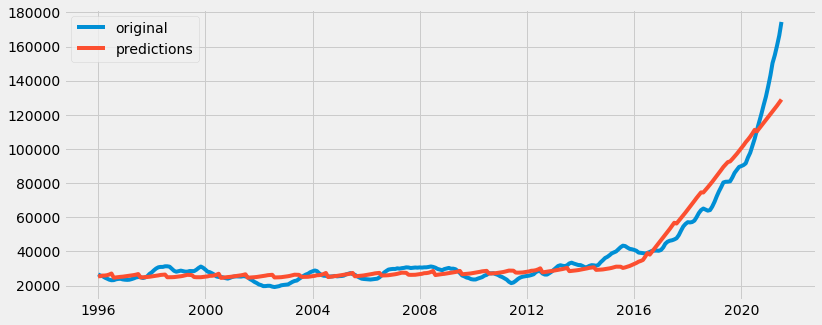

In [135]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(columbus_43222_proph.ds, columbus_43222_proph.y, label='original')
ax.plot(y_hat_prophet_full.ds, y_hat_prophet_full.yhat, label='predictions')
ax.legend();